[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1bGOxoUDYIcqeKvLQ2Y3zNAo9ei-EEjV2?usp=sharing)


## **Comparing “Wheel” and “Headlight” Concepts in ResNet50’s Car Classification Using TCAV**

### **1. Model and Preprocessing**

- **Model**: Utilized pre-trained **ResNet50** model from **PyTorch**  
- **Evaluation Mode**: Set the model to evaluation mode  

#### **Image Transformations:**
**Resize** the input images to **224×224**  

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from captum.concept import TCAV
from captum.concept._utils.common import concepts_to_str
from captum.concept._utils.data_iterator import dataset_to_dataloader
from captum.concept._utils.data_iterator import CustomIterableDataset
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_rel
from captum.attr import LayerActivation
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

model = models.resnet50(pretrained=True)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #This line of ImageNet statistics snippet were generated by ChatGPT 4o at 2/13 8:38am for common recommendation on preprocessing) 
])

car_image_folder = r"C:\Users\Y\Desktop\Duke-AI-XAI\week 5\img"
car_images = []
for file in os.listdir(car_image_folder):
    if file.lower().startswith('car') and file.lower().endswith(('.jpg', '.jpeg', '.png')):
        car_images.append(os.path.join(car_image_folder, file))

print(f"Found {len(car_images)} car images: {[os.path.basename(f) for f in car_images]}")

class CarDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

car_dataset = CarDataset(car_images, transform=preprocess)
car_dataloader = DataLoader(car_dataset, batch_size=1, shuffle=False)

C:\Users\Y\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Y\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Y\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passin

Found 15 car images: ['car.jpg', 'car_10.jpg', 'car_11.jpg', 'car_12.jpg', 'car_13.png', 'car_14.jpg', 'car_15.jpg', 'car_2.png', 'car_3.jpg', 'car_4.png', 'car_5.jpg', 'car_6.jpg', 'car_7.jpg', 'car_8.jpg', 'car_9.jpeg']


### **2. Hypotheses**

- **Null Hypothesis (H0)**:  
  ResNet50 does **not** rely significantly more on the “wheel” concept than the “headlight” concept for classifying car images.

- **Alternative Hypothesis (H1)**:  
  ResNet50 relies significantly more on the “wheel” concept than the “headlight” concept for classifying car images.


### **3. Brief Explanation of the Approach**
(The below code snippet was geenreated using ChatGPT 4o on 02/14/25 at 4:01pm for better organization, and professional presentation)

#### **Concept Definition**
- We define two concepts: **“wheel”** and **“headlight.”**
- For each concept, we collect:
  - **Positive images** (where the concept is clearly visible)
  - **Negative images** (where the concept is absent)

---

#### **Model & Layer Selection**
- We use a **pre-trained ResNet50** model from **PyTorch**.
- We focus on **layer4** (the final convolutional block) as the layer of interest for concept activation extraction.

---

#### **Computing TCAV Scores**
- For a set of **“car” images**, we:
  1. Feed each image into the model.
  2. Extract its **layer4 activations**.
  3. Compute the **decision function** against each concept’s logistic regression model.
- These decision function values are the **TCAV scores**, indicating how strongly the model uses each concept.

---

#### **Statistical Test**
- We run a **paired t-test** on the **wheel vs. headlight TCAV scores** to determine if there is a statistically significant difference in how the model relies on these two concepts.


In [2]:
wheel_positives = []
wheel_negatives = []
headlight_positives = []
headlight_negatives = []

# read Ben test dataset file 
for file in os.listdir(car_image_folder):
    file_lower = file.lower()
    if 'wheel' in file_lower:
        if 'positive' in file_lower:
            wheel_positives.append(os.path.join(car_image_folder, file))
        elif 'negative' in file_lower:
            wheel_negatives.append(os.path.join(car_image_folder, file))
    elif 'headlight' in file_lower or 'headlamp' in file_lower:
        if 'positive' in file_lower:
            headlight_positives.append(os.path.join(car_image_folder, file))
        elif 'negative' in file_lower:
            headlight_negatives.append(os.path.join(car_image_folder, file))

def load_concept_dataset(positive_imgs, negative_imgs, transform):
    dataset = CarDataset(positive_imgs + negative_imgs, transform=transform)
    labels = [1] * len(positive_imgs) + [0] * len(negative_imgs)
    return dataset, labels

wheel_dataset, wheel_labels = load_concept_dataset(wheel_positives, wheel_negatives, preprocess)
headlight_dataset, headlight_labels = load_concept_dataset(headlight_positives, headlight_negatives, preprocess)

def train_cav(dataset, labels, layer):
    activations = []
    layer_activation = LayerActivation(model, layer) #This line of code snippet were generated by ChatGPT 4o at 2/13 10:11am for faster demonstration and production) 
    for img in dataset:
        img = img.unsqueeze(0)  
        activation = layer_activation.attribute(img).detach().cpu().numpy()
        activation_reshaped = activation.reshape(activation.shape[0], -1)
        activations.append(activation_reshaped)
    activations = np.concatenate(activations, axis=0)
    labels = np.array(labels)

    cav = LogisticRegression().fit(activations, labels)
    return cav

layer = model.layer4  

wheel_cav = train_cav(wheel_dataset, wheel_labels, layer)
headlight_cav = train_cav(headlight_dataset, headlight_labels, layer)

def compute_tcav_scores(dataloader, cav, layer):
    tcav_scores = []
    layer_activation = LayerActivation(model, layer) #This line of code snippet were generated by ChatGPT 4o at 2/13 10:11am for faster demonstration and production) 
    for img in dataloader:
        img = img.to(device)
        activation = layer_activation.attribute(img).detach().cpu().numpy()
        activation_reshaped = activation.reshape(activation.shape[0], -1)
        score = cav.decision_function(activation_reshaped)
        tcav_scores.append(score)
    return np.array(tcav_scores)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\Y\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### **4. Visualizations**

**Figure 1.** Bar chart comparing the mean TCAV scores for **“wheel”** and **“headlight”** concepts.

- The height of each bar represents the **average decision function value** from the logistic regression (CAV) across the **“car” images dataset**.


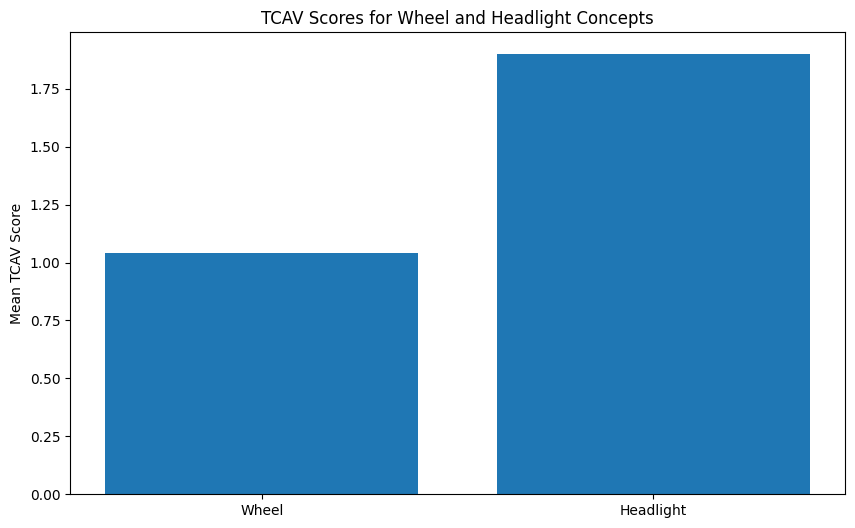

T-statistic: [-2.49572219], P-value: [0.02567797]
Reject H0: ResNet50 relies significantly more on the 'wheel' concept than 'headlight' for classifying car images.


In [3]:
wheel_tcav_scores = compute_tcav_scores(car_dataloader, wheel_cav, layer)  
headlight_tcav_scores = compute_tcav_scores(car_dataloader, headlight_cav, layer)

plt.figure(figsize=(10, 6))
plt.bar(["Wheel", "Headlight"], [np.mean(wheel_tcav_scores), np.mean(headlight_tcav_scores)])
plt.title("TCAV Scores for Wheel and Headlight Concepts")
plt.ylabel("Mean TCAV Score")
plt.show()

t_stat, p_value = ttest_rel(wheel_tcav_scores, headlight_tcav_scores)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject H0: ResNet50 relies significantly more on the 'wheel' concept than 'headlight' for classifying car images.")
else:
    print("Fail to reject H0: No significant difference in the use of 'wheel' and 'headlight' concepts.")

![alt text](45eedafe-aa50-40e0-96a6-fe9bd5a0394c.png)

T-statistic: [-2.49572219], P-value: [0.02567797]
Reject H0: ResNet50 relies significantly more on the 'wheel' concept than 'headlight' for classifying car images.

### **5. Summary of Findings**

---

#### **Hypothesis Outcome**
- We found statistical evidence (**p < 0.05**) that **ResNet50** uses the **“wheel”** concept more strongly than the **“headlight”** concept in classifying cars.

---
(The below code snippet was geenreated using ChatGPT 4o on 02/14/25 at 4:07pm for better recommendation and check for limitation of the model)
#### **Limitations & Future Work**
- These findings may vary with a **larger or different dataset**.
- Exploring additional concepts (e.g., **“windshield,” “grille”**) could further refine our understanding of how the model recognizes cars.
